In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
x_train_close = x_train[:,:,4] 
y_train_close = y_train[:,:,4] 
x_test_close = x_test[:,:,4] 

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1) 
close_prices.shape


(7661, 1500)

In [7]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [8]:
OHLC = full_df[:,:,1:5] 
OHLC.shape

(7661, 1500, 4)

In [18]:
x_test = x_test[:,:,1:5] 
x_test.shape

(535, 1380, 4)

# Preprocess Data

In [9]:
K = 120 
N = 60 
seq_len = 1500 
features = 4
X = [] 
Y = [] 

for j in tqdm(range(OHLC.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(OHLC[j, i:i+N, :]) 
        Y.append(OHLC[j, i+N+K, -1]) # get close prices as target
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape


100%|██████████| 7661/7661 [00:10<00:00, 718.57it/s]


((10112520, 60, 4), (10112520,))

# Define Model

In [10]:
d_k = 256
d_v = 256
n_heads = 8
ff_dim = 256

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [12]:
class SingleAttention(Layer): 
    def __init__(self, d_k, d_v): 
        super(SingleAttention, self).__init__() 
        self.d_k = d_k 
        self.d_v = d_v 
    
    def build(self, input_shape): 
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform') 
        
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0]) 
        k = self.key(inputs[1]) 
        attn_weights = tf.matmul(q, k, transpose_b=True) 
        attn_weights = tf.map_fn(lambda x : x / np.sqrt(self.d_k), attn_weights) 
        attn_weights = tf.nn.softmax(attn_weights, axis = -1) 
        v = self.value(inputs[2]) 
        attn_out = tf.matmul(attn_weights, v) 
        return attn_out
        

In [13]:
''' 
Multihead attention
concatenate the attention weights of n single head attention layers and then appply a non-linear transformation with a dense layer
'''
class MultiHeadAttention(Layer): 
    def __init__(self, d_k, d_v, n_heads): 
        super(MultiHeadAttention, self).__init__() 
        self.d_k = d_k 
        self.d_v = d_v 
        self.n_heads = n_heads 
        self.attn_heads = list() 
    
    def build(self, input_shape): 
        for n in range(self.n_heads): 
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v)) 
        
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform') 
    
    def call(self, inputs): 
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)] 
        concat_attn = tf.concat(attn, axis = -1) 
        multi_linear = self.linear(concat_attn) 
        return multi_linear

In [14]:
class TransformerEncoder(Layer): 
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout = 0.1, **kwargs): 
        super(TransformerEncoder, self).__init__() 
        self.d_k = d_k 
        self.d_v = d_v 
        self.n_heads = n_heads 
        self.ff_dim = ff_dim 
        self.attn_heads = list() 
        self.dropout_rate = dropout
    
    def build(self, input_shape): 
        self.attn_multi = MultiHeadAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
        self.ff1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu') 
        self.ff2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6) 
        
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs) 
        attn_layer = self.attn_dropout(attn_layer) 
        attn_layer = self.attn_normalize(inputs[0] + attn_layer) 
        
        ff_layer = self.ff1(attn_layer)
        ff_layer = self.ff2(ff_layer) 
        ff_layer = self.ff_dropout(ff_layer) 
        ff_layer = self.ff_normalize(attn_layer + ff_layer) 
        return ff_layer 
    
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config

        

In [15]:
def build_model(): 
    time_embedding = Time2Vector(N)
    attn_layer = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    inputs = Input((N, features))  
    bn = BatchNormalization()(inputs)
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = attn_layer((x,x,x)) 
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x) 
    x = Concatenate()([gap,gmp]) 
    x = Dropout(0.2)(x) 
    x = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Dropout(0.2)(x) 
    outputs = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','mape'])
    return model 

In [16]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 6)        0           batch_normalization[0][0]        
                                                                 time2_vector[0][0]           

In [17]:
model_path = 'Transformer_Time2Vec_OHLC_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(x=X, 
                    y=Y, 
                    batch_size = 256, 
                    epochs = 100, 
                    callbacks = [learning_rate_reduction, checkpoint, early_stopping], 
                    validation_split = 0.1)


Epoch 1/100
20403/35552 [================>.............] - ETA: 1:29:46 - loss: 0.0097 - mse: 0.0097 - mae: 0.0416 - mape: 4.1623

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29182/35552 [=======================>......] - ETA: 37:43 - loss: 0.0073 - mse: 0.0073 - mae: 0.0343 - mape: 3.4333

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35552/35552 [==============================] - 13275s 373ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0310 - mape: 3.1008 - val_loss: 3.3362e-04 - val_mse: 3.3362e-04 - val_mae: 0.0122 - val_mape: 1.2278

Epoch 00001: val_loss improved from inf to 0.00033, saving model to Transformer_Time2Vec_OHLC_epoch_001_val_0.000.h5
Epoch 2/100
 1793/35552 [>.............................] - ETA: 3:41:04 - loss: 2.8251e-04 - mse: 2.8251e-04 - mae: 0.0105 - mape: 1.0549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5980/35552 [====>.........................] - ETA: 3:14:04 - loss: 2.8334e-04 - mse: 2.8334e-04 - mae: 0.0105 - mape: 1.0540

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11111/35552 [========>.....................] - ETA: 2:39:58 - loss: 2.8319e-04 - mse: 2.8319e-04 - mae: 0.0105 - mape: 1.0537

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16822/35552 [=============>................] - ETA: 2:02:09 - loss: 2.8300e-04 - mse: 2.8300e-04 - mae: 0.0105 - mape: 1.0532

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24388/35552 [===================>..........] - ETA: 1:12:36 - loss: 2.8265e-04 - mse: 2.8265e-04 - mae: 0.0105 - mape: 1.0524

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35552/35552 [==============================] - 14273s 401ms/step - loss: 2.8228e-04 - mse: 2.8228e-04 - mae: 0.0105 - mape: 1.0515 - val_loss: 3.7448e-04 - val_mse: 3.7448e-04 - val_mae: 0.0126 - val_mape: 1.2634

Epoch 00002: val_loss did not improve from 0.00033
Epoch 3/100
  240/35552 [..............................] - ETA: 3:30:32 - loss: 2.5832e-04 - mse: 2.5832e-04 - mae: 0.0102 - mape: 1.0230

KeyboardInterrupt: 

# Make Prediction

In [21]:
best_model = load_model('Transformer_Time2Vec_OHLC_epoch_001_val_0.000.h5', custom_objects = {'Time2Vector':Time2Vector, 'TransformerEncoder':TransformerEncoder})


In [22]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 6)        0           batch_normalization[0][0]        
                                                                 time2_vector_2[0][0]         

In [25]:
## We need to preprocess inputs for prediction 
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-N-K-120, seq_len-N-K):
        X_test.append(x_test[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,features))


100%|██████████| 535/535 [00:00<00:00, 16218.34it/s]


In [26]:
X_test.shape

(64200, 60, 4)

In [27]:
predicted = best_model.predict(X_test)
predicted = predicted.reshape((-1,120))

In [28]:
predicted.shape

(535, 120)

In [29]:
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:  
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)


100%|██████████| 535/535 [00:00<00:00, 4048.51it/s]


In [30]:
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times

In [31]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.508333,85
1,7662,0.833333,34
2,7663,0.375000,84
3,7664,0.900000,15
4,7665,0.083333,119
...,...,...,...
530,8191,1.000000,9
531,8192,1.000000,100
532,8193,0.333333,73
533,8194,1.000000,1


In [32]:
submission.to_csv('Transformer_Time2Vec_1epoch.csv',index=False)

# Visualize Plots

In [34]:
predicted_train = best_model.predict(X[:2400,])
predicted_train = predicted_train.reshape((-1,120))


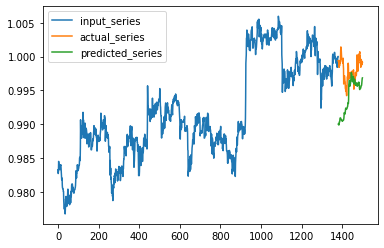

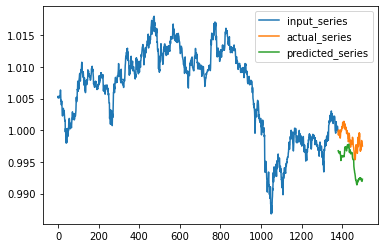

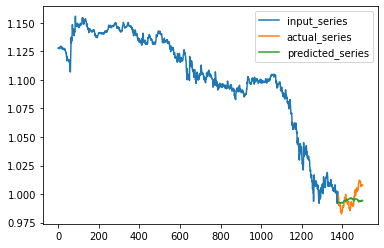

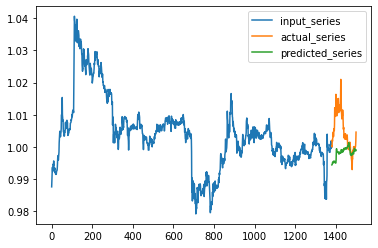

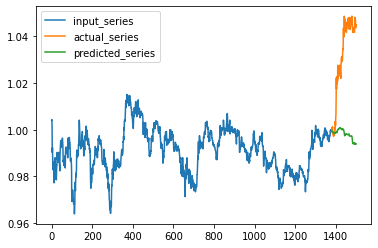

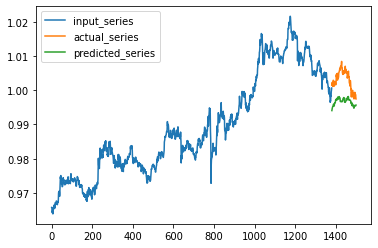

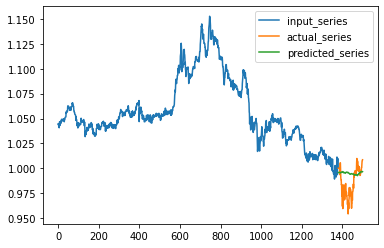

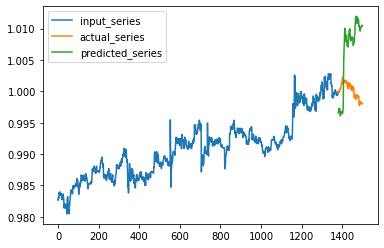

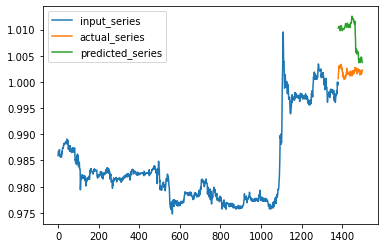

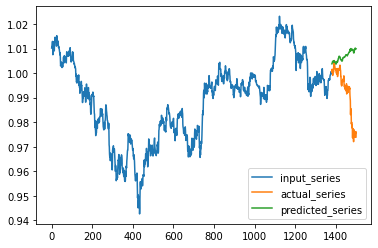

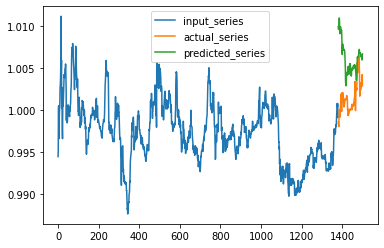

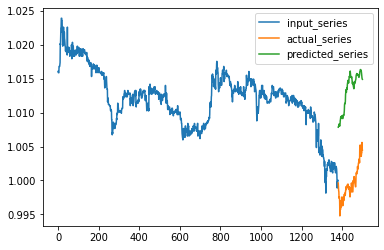

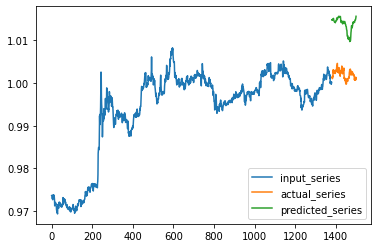

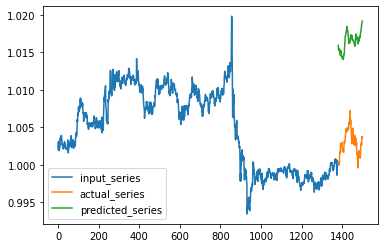

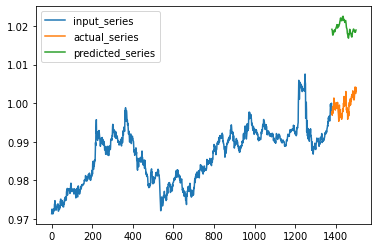

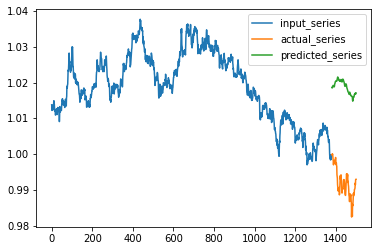

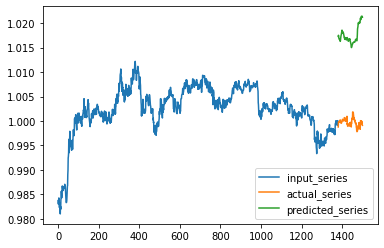

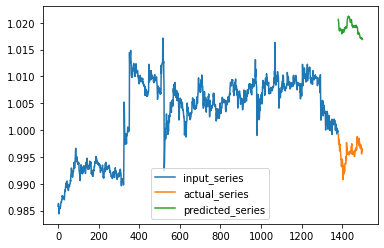

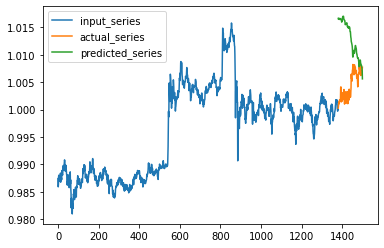

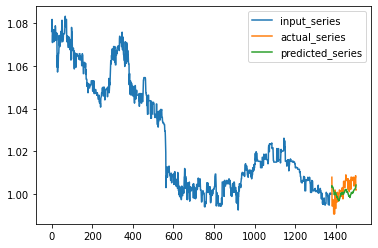

In [35]:
for i in range(20): 
    plt.plot() 
    plot_series(x_train_close[i,:], y_train_close[i,:], predicted_train[i,:])
    plt.show()
